# Mean Average Precision with [Weighted boxes fusion](#https://github.com/ZFTurbo/Weighted-Boxes-Fusion)
```
@article{solovyev2021weighted,
  title={Weighted boxes fusion: Ensembling boxes from different object detection models},
  author={Solovyev, Roman and Wang, Weimin and Gabruseva, Tatiana},
  journal={Image and Vision Computing},
  pages={1-6},
  year={2021},
  publisher={Elsevier}
}
```


# [Object-Detection-Metrics](#https://github.com/rafaelpadilla/Object-Detection-Metrics)
```
@Article{electronics10030279,  
AUTHOR = {Padilla, Rafael and Passos, Wesley L. and Dias, Thadeu L. B. and Netto, Sergio L. and da Silva, Eduardo A. B.},  
TITLE = {A Comparative Analysis of Object Detection Metrics with a Companion Open-Source Toolkit},  
JOURNAL = {Electronics},  
VOLUME = {10},  
YEAR = {2021},  
NUMBER = {3},  
ARTICLE-NUMBER = {279},  
URL = {https://www.mdpi.com/2079-9292/10/3/279},  
ISSN = {2079-9292},  
DOI = {10.3390/electronics10030279}  
}
```

In [1]:
from IPython.display import clear_output
!pip install ensemble-boxes
clear_output()

In [2]:
import ast
import json
import os
import re
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
from ensemble_boxes import *
from IPython.core.interactiveshell import InteractiveShell

from numba import cuda
from PIL import Image
from tensorflow import keras
from tqdm import tqdm

from test_utils.test_utils import Generator, Test
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sample_submission = pd.read_csv("/app/_data/sample_submission.csv")
sub_study = sample_submission[
    sample_submission["id"].str.contains("_study")
].reset_index(drop=True)
sub_image = sample_submission[
    sample_submission["id"].str.contains("_image")
].reset_index(drop=True)
if sample_submission.shape[0] == 2477:
    TRAIN_MODE = True
else:
    TRAIN_MODE = False
OBJ_DET = True
CLASSIFICATION = False
NORM = False
CROP = False
TRAIN_MODE

True

In [4]:
TRAIN_MODE = True

## Metric on train data

In [5]:
TEST_PATH = "/app/_data/train/"
TEST_JPG_PATH = "/app/_data/tmp/"
METADATA_PATH = "/app/_data//dict_metadata.json"
CROP_MODEL_PATH = "/app/_data/models/CropBest/EffB0_3.h5" if CROP else None
MODEL_PATH = [
    "/app/_data/models/EffB7_cropped/",
]
MODEL_2CL_PATH = None
SAVE_BBOX_PATH = "/app/_data/tmp/labels/"
RESIZED_YOLO_PATH = '/app/_data/tmp_1024/'
CACHE_CLASS_PATH = "/app/_data/class_img_path/"


In [7]:
shutil.rmtree("/app/_data/tmp/")
shutil.rmtree(CACHE_CLASS_PATH)
shutil.rmtree(RESIZED_YOLO_PATH)
test_df = Test.prepare_data(
    data_path=TEST_PATH,
    path_to_save=TEST_JPG_PATH,
    train_mode=TRAIN_MODE,
    n_train_sample=1000,
    norm=False,
    crop_model_path=CROP_MODEL_PATH,
    classification_img_path=CACHE_CLASS_PATH,
    img_size = 600,
    resized_yolo_path = RESIZED_YOLO_PATH,
    yolo_img_size=1024,
    npy_yolo=True,
)
test_df.head()

100%|██████████| 1000/1000 [04:03<00:00,  4.10it/s]
/app/src/test_utils/test_utils.py:145: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df["path"] = test_df["path"].str.replace("\../", "/kaggle/")


path StudyInstanceUID  \
0  /app/_data/train/9178d88ead3c/2ed92f0daec3/66b...     9178d88ead3c   
1  /app/_data/train/696814af65d5/a41993382487/c69...     696814af65d5   
2  /app/_data/train/b6278022ae0b/1a10e5ec3ad6/0a2...     b6278022ae0b   
3  /app/_data/train/7607d10ce737/bc3e1a3b5e29/029...     7607d10ce737   
4  /app/_data/train/d8a361473402/859542f0ac5a/c9f...     d8a361473402   

          image modality PatientSex BodyPartExamined  \
0  66be1a0176b4       DX          F            CHEST   
1  c69780c33f5d       DX          M            CHEST   
2  0a29a6326e2b       CR          F                    
3  029fd29fcfff       DX          F            CHEST   
4  c9f8fff624b9       DX          M            CHEST   

  PhotometricInterpretation   width  height  
0               MONOCHROME2  2840.0  2590.0  
1               MONOCHROME2  4256.0  3488.0  
2               MONOCHROME2  2802.0  2801.0  
3               MONOCHROME1  2706.0  2600.0  
4               MONOCHROME2  2880.0  2400.0

In [8]:
path = '/app/_data/tmp_1024/'
img = np.load(path+os.listdir(path)[22])
img = np.stack([img,img,img], axis=-1)
img.shape

(838, 1024, 3)

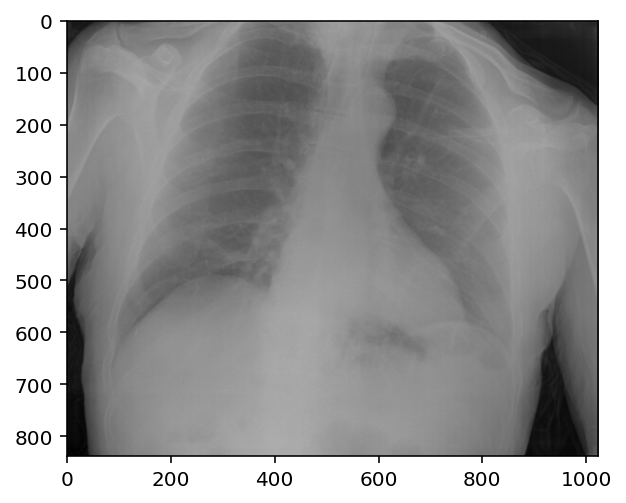

In [9]:
plt.imshow(img)
plt.show();

# yolo 5 classes

In [10]:
device = cuda.get_current_device()
device.reset()
%cd /app/_data/ScaledYOLOv4/mish-cuda
!python setup.py build install
%cd /app/_data/ScaledYOLOv4
clear_output()

In [11]:
!python detect.py --weights /app/_data/ScaledYOLOv4/runs/5cl_yolov4p7_42/weights/best_5cl_yolov4p7_42_strip.pt \
                  --source {RESIZED_YOLO_PATH} \
                  --img-size 1024 \
                  --conf-thres 0.0001 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels0/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.0001, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels0/', save_txt=True, source='/app/_data/tmp_1024/', update=False, view_img=False, weights=['/app/_data/ScaledYOLOv4/runs/5cl_yolov4p7_42/weights/best_5cl_yolov4p7_42_strip.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)

Fusing layers... Model Summary: 503 layers, 2.86033e+08 parameters, 2.7862e+08 gradients
image 1/1031 /app/_data/tmp_1024/001398f4ff4f.npy: 896x1024 9 negatives, 5 typicals, 7 indeterminates, 5 atypicals, 125 opacitys, Done. (0.213s)
image 2/1031 /app/_data/tmp_1024/004cbd797cd1.npy: 1024x1024 4 negatives, 10 typicals, 5 indeterminates, 5 atypicals, 93 opacitys, Done. (0.207s)
image 3/1031 /app/_data/tmp_1024/0060e4f54aa8.npy: 896x1024 5 negatives, 14 typicals, 5 indeterminates, 4 atypicals, 134 opacitys, Done. (0.184s)
image 4/1031 /app/_data/tmp_1024/00e37a390f0f.npy: 896

In [13]:
label_cl = {"negative": 0, "typical": 1, "indeterminate": 2, "atypical": 3, "opacity": 4}
label_cl = {k:m for m,k in label_cl.items()}
bb_folders = [
    "/app/_data/tmp/labels0/"
]
for file in os.listdir("/app/_data/Object-Detection-Metrics/detections/"):
    if ".txt" in file:
        os.remove("/app/_data/Object-Detection-Metrics/detections/" + file)
for file in os.listdir("/app/_data/Object-Detection-Metrics/groundtruths/"):
    if ".txt" in file:
        os.remove("/app/_data/Object-Detection-Metrics/groundtruths/" + file)
if os.path.exists("/app/_data/Object-Detection-Metrics/results"):
    shutil.rmtree("/app/_data/Object-Detection-Metrics/results")
sub_image = pd.DataFrame(columns=["id", "PredictionString"])
WBF = True
WEIGHTS = None
iou_thr = 0.7
skip_box_thr = 0.01
sigma = 0.1
for file in os.listdir(bb_folders[0]):
    if ".txt" in file:
        img_name = file[:-4]
        w = test_df[test_df["image"] == img_name]["width"].values[0]
        h = test_df[test_df["image"] == img_name]["height"].values[0]
        bb_list = []
        conf_list = []
        class_list = []
        for folder in bb_folders:
            if file in os.listdir(folder):
                ls = np.loadtxt(folder + file)
                if ls.ndim == 1:
                    ls = ls.reshape(1, -1)
                boxes_list = ls[:, 1:5].copy()
                boxes_list_copy = ls[:, 1:5].copy()
                boxes_list_copy[:, 0] = boxes_list[:, 0] - boxes_list[:, 2] / 2
                boxes_list_copy[:, 1] = boxes_list[:, 1] - boxes_list[:, 3] / 2
                boxes_list_copy[:, 2] = boxes_list[:, 0] + boxes_list[:, 2] / 2
                boxes_list_copy[:, 3] = boxes_list[:, 1] + boxes_list[:, 3] / 2
                bb_list.append(boxes_list_copy)
                conf_list.append(ls[:, 5])
                class_list.append(ls[:,0])
        if WBF:
            boxes, scores, labels = weighted_boxes_fusion(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr,
            )
        xmin = boxes[:, 0] * w
        ymin = boxes[:, 1] * h
        xmax = boxes[:, 2] * w
        ymax = boxes[:, 3] * h
        list_pred_subm = [
            f"{label_cl[labels[i]]} {scores[i]} {xmin[i]} {ymin[i]} {xmax[i]} {ymax[i]}"
            for i in range(len(boxes))
        ]
        list_pred = [
            f"{labels[i]} {scores[i]} {xmin[i]} {ymin[i]} {xmax[i]} {ymax[i]}"
            for i in range(len(boxes))
        ]
        sub_image = sub_image.append(
            {
                "id": img_name + "_image",
                "PredictionString": " ".join(list_pred_subm),
            },
            ignore_index=True,
        )
        np.savetxt(
            "/app/_data/Object-Detection-Metrics/detections/" + img_name + ".txt",
            list_pred,
            fmt="%s",
        )
train = pd.read_csv("/app/_data/train.csv")
train['class_id'] = train['class'].replace({"negative": 0, "typical": 1, "indeterminate": 2, "atypical": 3, "opacity": 4})
train["image"] = train["image"].str[:-4]
test_df1 = test_df.merge(train[["image", "boxes",'class', 'class_id']], on="image", how="left")
sub_image["image"] = sub_image["id"].str[:-6]
test_df1 = test_df1.merge(sub_image, on="image", how="left")
for i in test_df1.index.tolist():
    w = test_df1.loc[i, "width"]
    h = test_df1.loc[i, "height"]
    image = test_df1.loc[i, "image"]
    bbox_list = []
    if test_df1.loc[i, "boxes"] == test_df1.loc[i, "boxes"]:
        boxes = ast.literal_eval(test_df1.loc[i, "boxes"])
       
        for box in boxes:
            bbox_list.append(
                [
                    "4.0",
                    box["x"],
                    box["y"],
                    (box["x"] + box["width"]),
                    (box["y"] + box["height"]),
                ]
            )
    bbox_list.append([test_df1.loc[i,'class_id'].astype('float'), 0,0,w,h])
    np.savetxt(
        "/app/_data/Object-Detection-Metrics/groundtruths/" + image + ".txt",
        bbox_list,
        fmt="%s",
    )
%cd /app/_data/Object-Detection-Metrics
!python pascalvoc.py -gtformat xyrb -detformat xyrb 
# -gtcoords rel -detcoords rel -imgsize 

/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:76: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/usr/local/lib/python3.8/dist-packages/e

/app/_data/Object-Detection-Metrics


####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                                                                              #
#                                                                                                  #
# PLEASE ACCESS IT ACCESSED AT:                                                                    #
# https://github.com/rafaelpadilla/review_object_detection_metrics                                 #
#                                                                                                  #
# @Article{electronics10030279,                                                                    #
#     author         = {Padilla, Rafael and Passos, W

In [16]:
sub_image.loc[1,'PredictionString']

'typical 0.941263 20.72523600000015 0.0012180000000350244 3014.2339960000004 2433.036606 opacity 0.757442 1640.358996 364.5108599999999 2362.826988 1626.962988 opacity 0.749634 367.15700799999996 257.82502200000005 1169.569744 1588.438866 opacity 0.325975 35.53200799999994 0.0 3026.0785039999996 2427.1086 indeterminate 0.29276 0.0 2.9633940000001577 3032.0 2435.998782 opacity 0.258907 429.337264 234.116652 778.726752 743.8399079999999 opacity 0.227927 378.998484 198.55470600000004 888.2804920000001 1303.9408620000002 opacity 0.174353 476.71074799999997 1093.533798 977.1089959999999 1535.0953379999999 atypical 0.113671 0.0015159999998752838 0.0 3017.19626 2436.0 opacity 0.0651829 488.555256 826.817376 1122.1947440000001 1576.584072 negative 0.055706 11.844508000000106 0.0 3017.19626 2424.146424 opacity 0.0381588 1829.8605120000002 361.54868400000004 2377.63376 1232.8181880000002 opacity 0.021698 663.248484 678.6415860000001 1225.826988 1671.416334 opacity 0.0128519 272.405492 542.32059 

# yolo

In [21]:
%cd /app/_data/ScaledYOLOv4
!python detect.py --weights /app/_data/ScaledYOLOv4/runs/exp8_yolov4lp7_3cl_42/weights/best_yolov4lp7_3cl_42_strip.pt \
                  --source {RESIZED_YOLO_PATH} \
                  --img-size 1024 \
                  --conf-thres 0.0001 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels0/ \
                  --augment

/app/_data/ScaledYOLOv4
Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.0001, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels0/', save_txt=True, source='/app/_data/tmp_1024/', update=False, view_img=False, weights=['/app/_data/ScaledYOLOv4/runs/exp8_yolov4lp7_3cl_42/weights/best_yolov4lp7_3cl_42_strip.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)

Fusing layers... Model Summary: 503 layers, 2.85989e+08 parameters, 2.78614e+08 gradients
image 1/1031 /app/_data/tmp_1024/001398f4ff4f.npy: 896x1024 175 typicals, 5 indeterminates, 5 atypicals, Done. (0.219s)
image 2/1031 /app/_data/tmp_1024/004cbd797cd1.npy: 1024x1024 217 typicals, 6 indeterminates, 6 atypicals, Done. (0.210s)
image 3/1031 /app/_data/tmp_1024/0060e4f54aa8.npy: 896x1024 225 typicals, 2 indeterminates, 2 atypicals, Done. (0.185s)
image 4/1031 /app/_data/tmp_1024/00e37a390f0f.npy: 896x1024 185 typicals, 2 indeterminates, 2 atyp

In [22]:
!python detect.py --weights /app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt \
                  --source {RESIZED_YOLO_PATH} \
                  --img-size 1024 \
                  --conf-thres 0.0001 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels1/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.0001, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels1/', save_txt=True, source='/app/_data/tmp_1024/', update=False, view_img=False, weights=['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
image 1/1031 /app/_data/tmp_1024/001398f4ff4f.npy: 896x1024 131 opacitys, Done. (0.212s)
image 2/1031 /app/_data/tmp_1024/004cbd797cd1.npy: 1024x1024 187 opacitys, Done. (0.211s)
image 3/1031 /app/_data/tmp_1024/0060e4f54aa8.npy: 896x1024 196 opacitys, Done. (0.185s)
image 4/1031 /app/_data/tmp_1024/00e37a390f0f.npy: 896x1024 133 opacitys, Done. (0.184s)
image 5/1031 /app/_data/tmp_1024/012f57190f1d.npy: 1024x1024 157 opacitys, Done. (0.184s)
image 6/1031 /app/_data/tmp_1024/01376c1ba556.npy: 896x1024 172 o

In [23]:
!python detect.py --weights /app/_data/yolov4p7weights/comp_1_42.pt \
                  --source {RESIZED_YOLO_PATH} \
                  --img-size 1024 \
                  --conf-thres 0.0001 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels2/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.0001, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels2/', save_txt=True, source='/app/_data/tmp_1024/', update=False, view_img=False, weights=['/app/_data/yolov4p7weights/comp_1_42.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
image 1/1031 /app/_data/tmp_1024/001398f4ff4f.npy: 896x1024 243 opacitys, Done. (0.219s)
image 2/1031 /app/_data/tmp_1024/004cbd797cd1.npy: 1024x1024 291 opacitys, Done. (0.211s)
image 3/1031 /app/_data/tmp_1024/0060e4f54aa8.npy: 896x1024 288 opacitys, Done. (0.191s)
image 4/1031 /app/_data/tmp_1024/00e37a390f0f.npy: 896x1024 183 opacitys, Done. (0.191s)
image 5/1031 /app/_data/tmp_1024/012f57190f1d.npy: 1024x1024 210 opacitys, Done. (0.191s)
image 6/1031 /app/_data/tmp_1024/01376c1ba556.npy: 896x1024 300 opacitys, Done. (0.191s

In [24]:
!python detect.py --weights /app/_data/yolov4p7weights/comp_2_42.pt\
                  --source {RESIZED_YOLO_PATH} \
                  --img-size 1024 \
                  --conf-thres 0.0001 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels3/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.0001, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels3/', save_txt=True, source='/app/_data/tmp_1024/', update=False, view_img=False, weights=['/app/_data/yolov4p7weights/comp_2_42.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
image 1/1031 /app/_data/tmp_1024/001398f4ff4f.npy: 896x1024 187 opacitys, Done. (0.221s)
image 2/1031 /app/_data/tmp_1024/004cbd797cd1.npy: 1024x1024 210 opacitys, Done. (0.210s)
image 3/1031 /app/_data/tmp_1024/0060e4f54aa8.npy: 896x1024 300 opacitys, Done. (0.201s)
image 4/1031 /app/_data/tmp_1024/00e37a390f0f.npy: 896x1024 173 opacitys, Done. (0.190s)
image 5/1031 /app/_data/tmp_1024/012f57190f1d.npy: 1024x1024 239 opacitys, Done. (0.189s)
image 6/1031 /app/_data/tmp_1024/01376c1ba556.npy: 896x1024 228 opacitys, Done. (0.193s

# weighted_boxes_fusion

In [25]:
bb_folders = [
    "/app/_data/tmp/labels0/",
    "/app/_data/tmp/labels1/",
    "/app/_data/tmp/labels2/",
    "/app/_data/tmp/labels3/",
]

In [26]:
for file in os.listdir("/app/_data/Object-Detection-Metrics/detections/"):
    if ".txt" in file:
        os.remove("/app/_data/Object-Detection-Metrics/detections/" + file)
for file in os.listdir("/app/_data/Object-Detection-Metrics/groundtruths/"):
    if ".txt" in file:
        os.remove("/app/_data/Object-Detection-Metrics/groundtruths/" + file)
if os.path.exists("/app/_data/Object-Detection-Metrics/results"):
    shutil.rmtree("/app/_data/Object-Detection-Metrics/results")
sub_image = pd.DataFrame(columns=["id", "PredictionString"])
NMS = False
SOFT_NMS = False
NMW = False
WBF = True
WEIGHTS = None
iou_thr = 0.65
skip_box_thr = 0.01
sigma = 0.1
for file in os.listdir(bb_folders[0]):
    if ".txt" in file:
        img_name = file[:-4]
        w = test_df[test_df["image"] == img_name]["width"].values[0]
        h = test_df[test_df["image"] == img_name]["height"].values[0]
        bb_list = []
        conf_list = []
        class_list = []
        for folder in bb_folders:
            if file in os.listdir(folder):
                ls = np.loadtxt(folder + file)
                if ls.ndim == 1:
                    ls = ls.reshape(1, -1)
                boxes_list = ls[:, 1:5].copy()
                boxes_list_copy = ls[:, 1:5].copy()
                boxes_list_copy[:, 0] = boxes_list[:, 0] - boxes_list[:, 2] / 2
                boxes_list_copy[:, 1] = boxes_list[:, 1] - boxes_list[:, 3] / 2
                boxes_list_copy[:, 2] = boxes_list[:, 0] + boxes_list[:, 2] / 2
                boxes_list_copy[:, 3] = boxes_list[:, 1] + boxes_list[:, 3] / 2
                bb_list.append(boxes_list_copy)
                conf_list.append(ls[:, 5])
                class_list.append(['0']*ls.shape[0])
        if WBF:
            boxes, scores, labels = weighted_boxes_fusion(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr,
            )
        elif NMS:
            boxes, scores, labels = nms(
                bb_list, conf_list, class_list, weights=WEIGHTS, iou_thr=iou_thr
            )
        elif SOFT_NMS:
            boxes, scores, labels = soft_nms(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=iou_thr,
                sigma=sigma,
                thresh=skip_box_thr,
            )
        elif NMW:
            boxes, scores, labels = non_maximum_weighted(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr,
            )
        xmin = boxes[:, 0] * w
        ymin = boxes[:, 1] * h
        xmax = boxes[:, 2] * w
        ymax = boxes[:, 3] * h
        list_pred_rel = [
            f"opacity {scores[i]} {boxes[:, 0][i]} {boxes[:, 1][i]} {boxes[:, 2][i]} {boxes[:, 3][i]}"
            for i in range(len(boxes))
        ]
        list_pred = [
            f"opacity {scores[i]} {xmin[i]} {ymin[i]} {xmax[i]} {ymax[i]}"
            for i in range(len(boxes))
        ]
        sub_image = sub_image.append(
            {
                "id": img_name + "_image",
                "PredictionString": " ".join(list_pred),
            },
            ignore_index=True,
        )
        np.savetxt(
            "/app/_data/Object-Detection-Metrics/detections/" + img_name + ".txt",
            list_pred,
            fmt="%s",
        )
train = pd.read_csv("/app/_data/train.csv")
train["image"] = train["image"].str[:-4]
test_df1 = test_df.merge(train[["image", "boxes"]], on="image", how="left")
sub_image["image"] = sub_image["id"].str[:-6]
test_df1 = test_df1.merge(sub_image, on="image", how="left")
for i in test_df1.index.tolist():
    w = test_df1.loc[i, "width"]
    h = test_df1.loc[i, "height"]
    image = test_df1.loc[i, "image"]
    if test_df1.loc[i, "boxes"] == test_df1.loc[i, "boxes"]:
        boxes = ast.literal_eval(test_df1.loc[i, "boxes"])
        bbox_list = []
        for box in boxes:
            bbox_list.append(
                [
                    "opacity",
                    box["x"],
                    box["y"],
                    (box["x"] + box["width"]),
                    (box["y"] + box["height"]),
                ]
            )
        np.savetxt(
            "/app/_data/Object-Detection-Metrics/groundtruths/" + image + ".txt",
            bbox_list,
            fmt="%s",
        )
%cd /app/_data/Object-Detection-Metrics
!python pascalvoc.py -gtformat xyrb -detformat xyrb 
# -gtcoords rel -detcoords rel -imgsize 

/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:64: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:76: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')


/app/_data/Object-Detection-Metrics


####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                                                                              #
#                                                                                                  #
# PLEASE ACCESS IT ACCESSED AT:                                                                    #
# https://github.com/rafaelpadilla/review_object_detection_metrics                                 #
#                                                                                                  #
# @Article{electronics10030279,                                                                    #
#     author         = {Padilla, Rafael and Passos, W

# yolo ansamble

In [27]:
%cd /app/_data/ScaledYOLOv4
!python detect.py --weights /app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt /app/_data/yolov4p7weights/comp_2_42.pt \
                    /app/_data/yolov4p7weights/comp_1_42.pt \
                  --source {RESIZED_YOLO_PATH} \
                  --img-size 1024 \
                  --conf-thres 0.0001 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels4/ \
                  --augment

/app/_data/ScaledYOLOv4
Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.0001, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels4/', save_txt=True, source='/app/_data/tmp_1024/', update=False, view_img=False, weights=['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt', '/app/_data/yolov4p7weights/comp_2_42.pt', '/app/_data/yolov4p7weights/comp_1_42.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24268MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Ensemble created with ['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt', '/app/_data/yolov4p7weights/comp_2_42.pt', '/app/_data/yolov4p7weights/comp_1_42.pt']

image 1/1031 /app/_data/tmp_1024/001398f4ff4f.npy

In [28]:
bb_folders = ["/app/_data/tmp/labels4/"]
for file in os.listdir("/app/_data/Object-Detection-Metrics/detections/"):
    if ".txt" in file:
        os.remove("/app/_data/Object-Detection-Metrics/detections/" + file)
for file in os.listdir("/app/_data/Object-Detection-Metrics/groundtruths/"):
    if ".txt" in file:
        os.remove("/app/_data/Object-Detection-Metrics/groundtruths/" + file)
if os.path.exists("/app/_data/Object-Detection-Metrics/results"):
    shutil.rmtree("/app/_data/Object-Detection-Metrics/results")
sub_image = pd.DataFrame(columns=["id", "PredictionString"])
NMS = False
SOFT_NMS = False
NMW = False
WBF = True
WEIGHTS = None
iou_thr = 0.63
skip_box_thr = 0.01
sigma = 0.1
for file in os.listdir(bb_folders[0]):
    if ".txt" in file:
        img_name = file[:-4]
        w = test_df[test_df["image"] == img_name]["width"].values[0]
        h = test_df[test_df["image"] == img_name]["height"].values[0]
        bb_list = []
        conf_list = []
        class_list = []
        for folder in bb_folders:
            if file in os.listdir(folder):
                ls = np.loadtxt(folder + file)
                if ls.ndim == 1:
                    ls = ls.reshape(1, -1)
                boxes_list = ls[:, 1:5].copy()
                boxes_list_copy = ls[:, 1:5].copy()
                boxes_list_copy[:, 0] = boxes_list[:, 0] - boxes_list[:, 2] / 2
                boxes_list_copy[:, 1] = boxes_list[:, 1] - boxes_list[:, 3] / 2
                boxes_list_copy[:, 2] = boxes_list[:, 0] + boxes_list[:, 2] / 2
                boxes_list_copy[:, 3] = boxes_list[:, 1] + boxes_list[:, 3] / 2
                bb_list.append(boxes_list_copy)
                conf_list.append(ls[:, 5])
                class_list.append(ls[:, 0])
        if WBF:
            boxes, scores, labels = weighted_boxes_fusion(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr,
            )
        elif NMS:
            boxes, scores, labels = nms(
                bb_list, conf_list, class_list, weights=WEIGHTS, iou_thr=iou_thr
            )
        elif SOFT_NMS:
            boxes, scores, labels = soft_nms(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=iou_thr,
                sigma=sigma,
                thresh=skip_box_thr,
            )
        elif NMW:
            boxes, scores, labels = non_maximum_weighted(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr,
            )
        xmin = boxes[:, 0] * w
        ymin = boxes[:, 1] * h
        xmax = boxes[:, 2] * w
        ymax = boxes[:, 3] * h
        list_pred_rel = [
            f"opacity {scores[i]} {boxes[:, 0][i]} {boxes[:, 1][i]} {boxes[:, 2][i]} {boxes[:, 3][i]}"
            for i in range(len(boxes))
        ]
        list_pred = [
            f"opacity {scores[i]} {xmin[i]} {ymin[i]} {xmax[i]} {ymax[i]}"
            for i in range(len(boxes))
        ]
        sub_image = sub_image.append(
            {
                "id": img_name + "_image",
                "PredictionString": " ".join(list_pred),
            },
            ignore_index=True,
        )
        np.savetxt(
            "/app/_data/Object-Detection-Metrics/detections/" + img_name + ".txt",
            list_pred,
            fmt="%s",
        )
train = pd.read_csv("/app/_data/train.csv")
train["image"] = train["image"].str[:-4]
test_df1 = test_df.merge(train[["image", "boxes"]], on="image", how="left")
sub_image["image"] = sub_image["id"].str[:-6]
test_df1 = test_df1.merge(sub_image, on="image", how="left")
for i in test_df1.index.tolist():
    w = test_df1.loc[i, "width"]
    h = test_df1.loc[i, "height"]
    image = test_df1.loc[i, "image"]
    if test_df1.loc[i, "boxes"] == test_df1.loc[i, "boxes"]:
        boxes = ast.literal_eval(test_df1.loc[i, "boxes"])
        bbox_list = []
        for box in boxes:
            bbox_list.append(
                [
                    "opacity",
                    box["x"],
                    box["y"],
                    (box["x"] + box["width"]),
                    (box["y"] + box["height"]),
                ]
            )
        np.savetxt(
            "/app/_data/Object-Detection-Metrics/groundtruths/" + image + ".txt",
            bbox_list,
            fmt="%s",
        )
%cd /app/_data/Object-Detection-Metrics
!python pascalvoc.py -gtformat xyrb -detformat xyrb

/app/_data/Object-Detection-Metrics


####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                                                                              #
#                                                                                                  #
# PLEASE ACCESS IT ACCESSED AT:                                                                    #
# https://github.com/rafaelpadilla/review_object_detection_metrics                                 #
#                                                                                                  #
# @Article{electronics10030279,                                                                    #
#     author         = {Padilla, Rafael and Passos, W

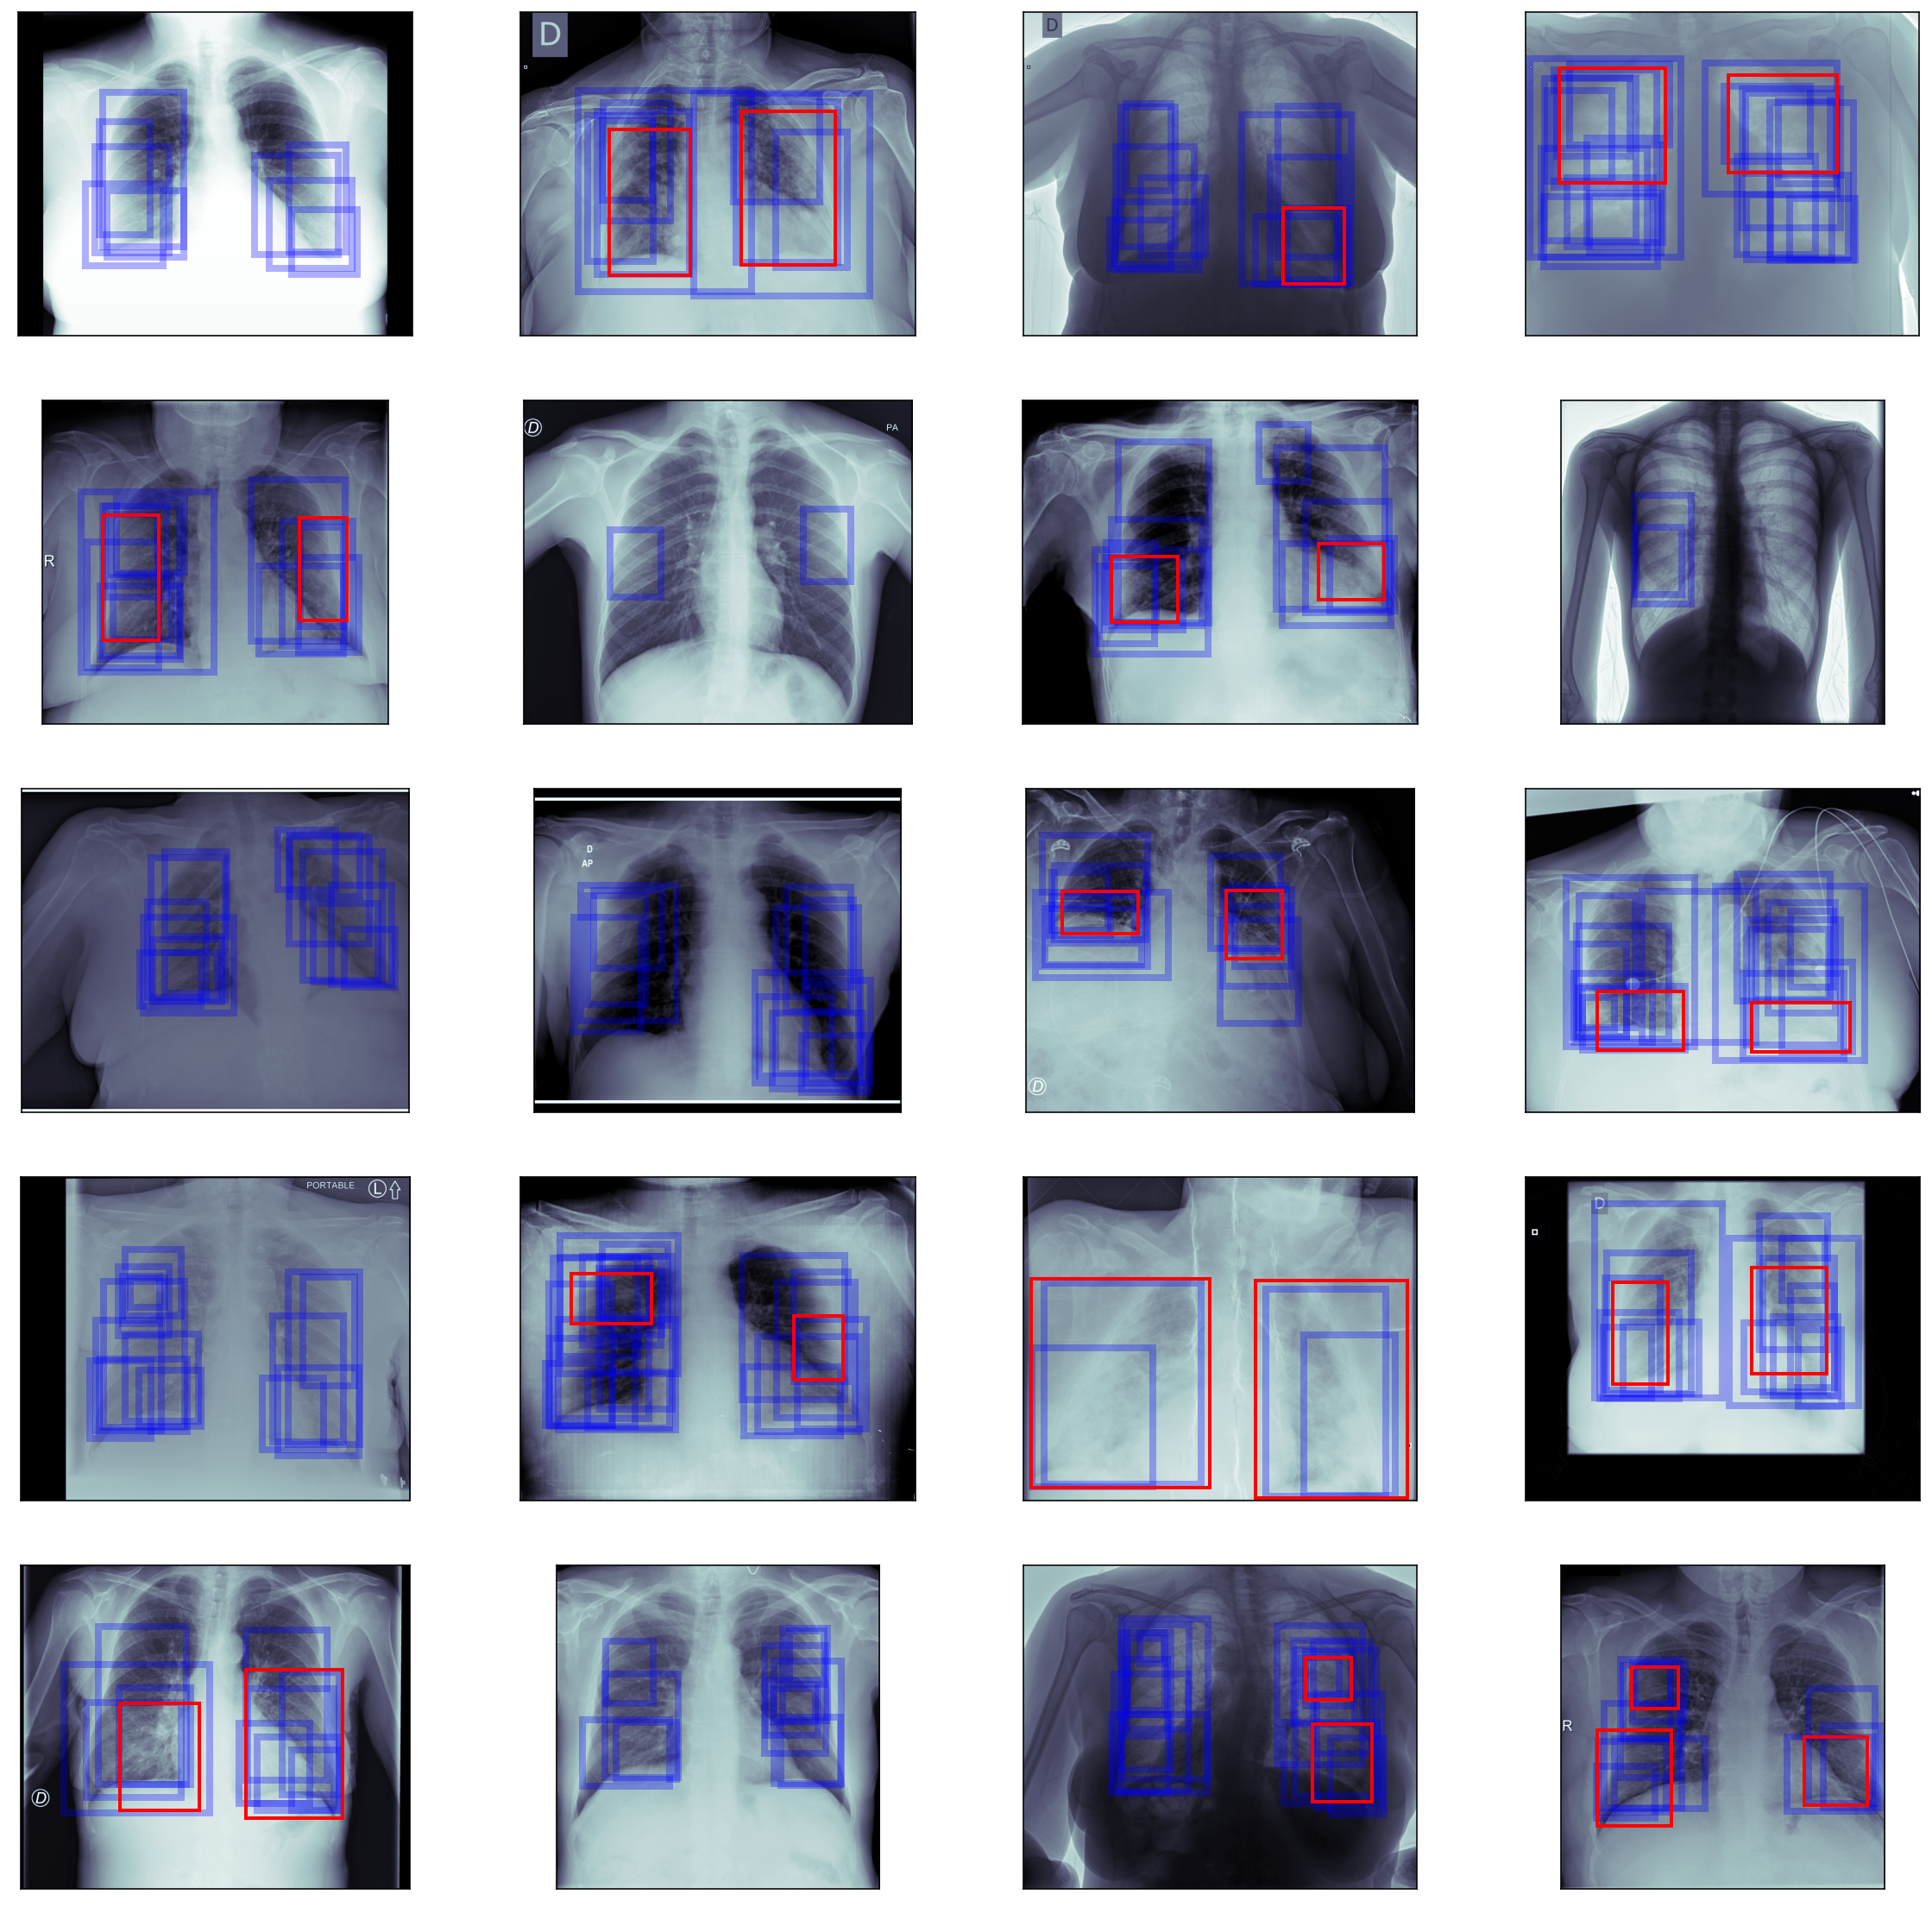

In [29]:
plt.figure(figsize=(20, 20))
sample_df = test_df1.sample(20).reset_index(drop=True)
for i in range(20):
    img_name = sample_df.loc[i, "image"]
    img = dicom.dcmread(sample_df.loc[i]["path"])
    img = img.pixel_array
    ax = plt.subplot(5, 4, i + 1)
    boxes = []
    if sample_df.loc[i, "PredictionString"] == sample_df.loc[i, "PredictionString"]:
        raw_boxes = sample_df.loc[i, "PredictionString"].split()
        for j in range(0, len(raw_boxes), 6):
            boxes.append(
                [
                    int(float(raw_boxes[j + 2])),
                    int(float(raw_boxes[j + 3])),
                    int(float(raw_boxes[j + 4])),
                    int(float(raw_boxes[j + 5])),
                ]
            )
        for box in boxes:
            rect = plt.Rectangle(
                (box[0], box[1]),
                (box[2] - box[0]),
                (box[3] - box[1]),
                ec="b",
                fc="none",
                lw=4.0,
                alpha=0.3,
            )
            ax.add_patch(rect)
    if sample_df.loc[i, "boxes"] == sample_df.loc[i, "boxes"]:
        boxes = ast.literal_eval(sample_df.loc[i, "boxes"])
        for box in boxes:
            rect = plt.Rectangle(
                (box["x"], box["y"]),
                box["width"],
                box["height"],
                ec="r",
                fc="none",
                lw=2.0,
            )
            ax.add_patch(rect)
    ax.imshow(img, cmap=plt.cm.bone)
    plt.xticks([])
    plt.yticks([])
plt.show();